# Figure 2

In [1]:
# loading libraries
library(readxl)
library(ggpubr)
library(ggdendroplot)
library(zoo)
library(dendextend)
library(Quartet)
source("func.R")
set.seed(36)

Loading required package: ggplot2


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



---------------------
Welcome to dendextend version 1.17.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: 'dendextend'


The following object is masked from 'package:ggpubr':

    rotate


The following object is masked from 'package:stats':

    cutree


Loading required package: TreeTools

Loading required package: ape


Attaching package: 'ape'


T

In [2]:
# directroy of the results from the in-vitro evolution experiment
dir_list <-  list.files("../data/in_vitro_evolution/", 
                        pattern= "_R$", full.names=TRUE)


## Creating marker lengths table

Setting up function

In [3]:
# create a table to which others can be joined 
get_markerlengths  <- function(dir_list) { 
  
  markerlengths <- NULL
  
  for (dir in dir_list) {

    split_dir <- str_split(dir[1], "/", simplify = TRUE)

    subject <- split_dir[length(split_dir)]  %>%  str_split("_") %>% purrr::map(1) %>% unlist 
    
    ## path to poly-G raw data directory (marker length files)
    marker_dir <- paste0(dir, "/repre_repli_data/")

    ## load marker lengths and get the average length of each marker in each sample
  get_markers <- function(marker_dir) {

  marker <- suppressMessages(read_tsv(marker_dir))
  
  # getting the marker name
  int_file <- tail(str_split(marker_dir, "/")[[1]], 1) 
  marker_name <- head(str_split(int_file, "_")[[1]], 1)

  cols <- NCOL(marker) +1 

  marker  %>% 
    rowid_to_column("length")  %>% 
    pivot_longer(cols=c(2:cols), names_to="sample", values_to="Frequency")  %>% 
    group_by(sample)  %>% 
    mutate(Frequency=Frequency/sum(Frequency),
            sample=str_remove(sample, "_[1-3]$")) %>%
    summarize(length = sum(length * Frequency)) %>%
    mutate(marker=marker_name) 
    
  }
  
  marker_files <- list.files(marker_dir, full.names = TRUE)

  markers <- lapply(marker_files, get_markers)
  markers <- bind_rows(markers)

    
    # subtract marker length of normal from each marker   
    root_sample <- str_subset(unique(markers$sample), "M2|M3") 
    markers <- markers %>% 
      group_by(marker) %>% 
      filter(any(str_detect(sample, "M2|M3"))) %>% 
      mutate(length = length - length[str_detect(sample, "M2|M3")]) %>% 
      ungroup %>% 
      mutate(sample=str_remove(sample, "_[1-3]$"))  %>% 
      as.data.table
    
    markers$subject <- subject
    
    markerlengths <- bind_rows(markerlengths, markers) 
    
  }
  return(markerlengths)
}


In [4]:
markerlengths <- get_markerlengths(dir_list) 

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(cols)

  # Now:
  data %>% select(all_of(cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


## Creating heatmaps for supplement

In [5]:
markerlengths_mss_hm <- markerlengths %>%
    filter(subject=="MSS1") %>% 
    mutate(subject = str_remove(subject, "1"), 
            sample=str_remove(sample, "MSS1"),
            sample=case_when(sample=="M3"~"MMRp-root",
                      str_detect(sample, "E6")&str_count(sample)==2~"MMRp-A",
                      str_detect(sample, "G6")&str_count(sample)==2~"MMRp-B",
                      str_detect(sample, "E5")&str_count(sample)==2~"MMRp-C",
                      str_detect(sample, "E6")&str_count(sample)==4~"MMRp-A1",
                      str_detect(sample, "G6")&str_count(sample)==4~"MMRp-B1",
                      str_detect(sample, "E5")&str_count(sample)==4~"MMRp-C1",
                      sample=="E63313" ~ "MMRp-A1a",
                      sample=="E6332A" ~ "MMRp-A1b",
                      sample=="E63336" ~ "MMRp-A1c",
                      sample=="G62332" ~ "MMRp-B1a",
                      sample=="G62333" ~ "MMRp-B1b",
                      sample=="G62335" ~ "MMRp-B1c",
                      sample=="E53311" ~ "MMRp-C1a",
                      sample=="E53315" ~ "MMRp-C1b"))

In [6]:
markerlengths_msi_hm <- markerlengths %>%
    filter(subject=="MSI1") %>% 
    mutate(subject = str_remove(subject, "1"), 
            sample=str_remove(sample, "MSI1"),
            sample=case_when(sample=="M2"~"MMRd-root",
                      str_detect(sample, "A")&str_count(sample)==2~"MMRd-A",
                      str_detect(sample, "B")&str_count(sample)==2~"MMRd-B",
                      str_detect(sample, "C")&str_count(sample)==2~"MMRd-C",
                      str_detect(sample, "A")&str_count(sample)==4~"MMRd-A1",
                      str_detect(sample, "B")&str_count(sample)==4~"MMRd-B1",
                      str_detect(sample, "C")&str_count(sample)==4~"MMRd-C1",
                      sample=="A33311" ~ "MMRd-A1a",
                      sample=="A33322" ~ "MMRd-A1b",
                      sample=="A3333C" ~ "MMRd-A1c",
                      sample=="B21418" ~ "MMRd-B1a",
                      sample=="B21419" ~ "MMRd-B1b",
                      sample=="B21435" ~ "MMRd-B1c",
                      sample=="C93113" ~ "MMRd-C1a",
                      sample=="C93133" ~ "MMRd-C1b"))

MSS heatmap

In [7]:
mss_hm <- create_heatmap("MSS", markerlengths_mss_hm)
ggsave("../plots/Supplementary_figures/Supplementary_Figure1a.pdf", mss_hm, height=11, width=33)

MSI heatmap

In [8]:
msi_hm <- create_heatmap("MSI", markerlengths_msi_hm)
ggsave("../plots/Supplementary_figures/Supplementary_Figure1b.pdf", msi_hm, height=11, width=33)

## Calculating L1 Distance

First getting all possible sample combinations

In [7]:
# find samples
samples <- markerlengths$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## remove all combintions where both primaries come from the same sample
combos <- combos_long %>% 
    mutate(sample_a=str_extract(a, "MSI|MSS"),
          sample_b=str_extract(b, "MSI|MSS"))  %>% 
    filter(sample_a==sample_b) %>% 
    dplyr::select(a, b)  

In [8]:
l1_list <- lapply(1:nrow(combos), get_l1_r_for_combination, combos, markerlengths)
l1_table  <- bind_rows(l1_list)

## Plotting L1 per Generation

Finding out how many generation separate two samples. M2/M3 are the root samples. All other samples with two letters (e.g. A3) have undergone 30 divisions from the root. Samples with 4 letters (e.g. A333) have undergone additional 30 divisions, so in total 60 divisions from the root. Finally, samples with 6 letters (e.g. A33311) grew for another 30 divisions, meaning they are 90 divisions from the root. From there, all possible combinations of cell divisions between two samples can be calculated.

In [9]:
cell_divs_tbl <- read_xlsx("../data/cell_division_numbers.xlsx")

In [10]:
divs_tbl <- cell_divs_tbl %>%
    mutate(
        sample_name = str_remove_all(sample_name, "_"),
        sample_name = str_remove_all(sample_name, "MSI"), 
        sample_name = str_remove_all(sample_name, "MSS")
    )

In [11]:
# setting up a function to get the number of cell divisions from the previous sample to this sample
get_divs <- function(sample) {
    divs_tbl %>%
        filter(sample_name == sample) %>%
        pull(divisions)
}
# vectorizing this function to have it work in "mutate"
get_divs_vect <- Vectorize(get_divs)

The cell divisions need to be counted from the previous generation, as each sample only represent the expansion of mutations acquired while growing the previous sample:

In [12]:
 msi_generations  <- l1_table %>% 
  filter(str_detect(a, "MSI")) %>% 
  mutate(A=str_remove(a, "MSI1"), B=str_remove(b, "MSI1"),
      length_A=str_count(A), length_B=str_count(B)) %>% 
  # annotate how many generations separate sample A and B
  mutate(generations = case_when(
      # from root to first generation
       length_A ==  2 & B == "M2" ~ get_divs_vect(B),
      # from root to second generation
       length_A ==  4 & B == "M2" ~ get_divs_vect(B) + get_divs_vect(str_sub(A, 1, 2)),
      # from root to third generation
       length_A ==  6 & B == "M2" ~
         get_divs_vect(B) + get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)),
      # within third generation
       length_A==length_B & str_detect(B, str_sub(A, 1,2)) ~ get_divs_vect((str_sub(A, 1,4)))*2,
      # between first and second generation of same clade
       str_detect(B, str_sub(A, 1, 2)) & length_A == 2 & length_B ==4 ~ get_divs_vect(A),
      # between second and third generation of same clade
       str_detect(B, str_sub(A, 1, 2)) & length_A == 4 & length_B ==6 ~ get_divs_vect(A),
      # between first and third generation of same clade
       str_detect(B, str_sub(A, 1,2)) & abs(length_A -length_B)==4 ~ get_divs_vect(str_sub(B, 1, 2)) +
       get_divs_vect(str_sub(B, 1, 4)),
      # between first generation
       length_A == length_B & !str_detect(B, "M2") & length_A == 2 ~ get_divs_vect("M2") * 2,
      # between second generation
       length_A == 4 & length_B == 4 & !str_detect(B, str_sub(A, 1, 2)) ~
          get_divs_vect("M2") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
          get_divs_vect(str_sub(B, 1, 2)),
      # between third generation
       length_A == 6 & length_B == 6 & !str_detect(B, str_sub(A, 1, 2)) ~
          get_divs_vect("M2") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
          get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)) +
          get_divs_vect(str_sub(B, 1, 4)),
      # between second generation of one clade and third generation of another clade
        !str_detect(B, str_sub(A, 1, 2)) & length_A == 4 & length_B == 6 ~
            get_divs_vect("M2") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
            get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(B, 1, 4)),
      # between second generation of one clade and third generation of another clade, reversed A and B
        !str_detect(B, str_sub(A, 1, 2)) & length_A == 6 & length_B == 4 ~
            get_divs_vect("M2") * 2 + get_divs_vect(str_sub(B, 1, 2)) +
            get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)),
      # between first generation of one clade and second generation of another clade
         !str_detect(B, str_sub(A, 1, 2)) & length_A == 2 & length_B == 4 ~
            get_divs_vect("M2") * 2 + get_divs_vect(str_sub(B, 1, 2)),
      # between first generation of one clade and second generation of another clade, reversed A and B
        !str_detect(B, str_sub(A, 1,2)) & length_A == 4 & length_B == 2 ~
            get_divs_vect("M2") * 2 + get_divs_vect(str_sub(A, 1, 2)),
     # between first generation of one clade and third generation of another clade
       !str_detect(B, str_sub(A, 1,2)) & length_A == 2 & length_B ==6 ~  get_divs_vect("M2") * 2 + 
         get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(B, 1, 4)),
     # between first generation of one clade and third generation of another clade, reversed A and B
         !str_detect(B, str_sub(A, 1,2)) & length_A == 6 & length_B ==2 ~ get_divs_vect("M2") * 2 + 
            get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4))
  )) %>% 
  select(-c(length_A,length_B))

In [13]:
mss_generations  <- l1_table %>% 
  filter(str_detect(a, "MSS")) %>% 
  mutate(A=str_remove(a, "MSS1"), B=str_remove(b, "MSS1"),
      length_A=str_count(A), length_B=str_count(B)) %>% 
  # annotate how many generations separate sample A and B
  mutate(generations = case_when(
      # from root to first generation
       length_A ==  2 & B == "M3" ~ get_divs_vect(B) ,
      # from root to second generation
       length_A ==  4 & B == "M3" ~ get_divs_vect(B) + get_divs_vect(str_sub(A, 1, 2)),
      # from root to third generation
       length_A ==  6 & B == "M3" ~
         get_divs_vect(B) + get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)),
      # within third generation
       length_A==length_B & str_detect(B, str_sub(A, 1,2)) ~ get_divs_vect((str_sub(A, 1,4)))*2,
      # between first and second generation of same clade
       str_detect(B, str_sub(A, 1, 2)) & length_A == 2 & length_B ==4 ~ get_divs_vect(A),
      # between second and third generation of same clade
       str_detect(B, str_sub(A, 1, 2)) & length_A == 4 & length_B ==6 ~ get_divs_vect(A),
      # between first and third generation of same clade
       str_detect(B, str_sub(A, 1,2)) & abs(length_A -length_B)==4 ~ get_divs_vect(str_sub(B, 1, 2)) +
       get_divs_vect(str_sub(B, 1, 4)),
      # between first generation
       length_A == length_B & !str_detect(B, "M3") & length_A == 2 ~ get_divs_vect("M3") * 2,
      # between second generation
       length_A == 4 & length_B == 4 & !str_detect(B, str_sub(A, 1, 2)) ~
          get_divs_vect("M3") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
          get_divs_vect(str_sub(B, 1, 2)),
      # between third generation
       length_A == 6 & length_B == 6 & !str_detect(B, str_sub(A, 1, 2)) ~
          get_divs_vect("M3") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
          get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)) +
          get_divs_vect(str_sub(B, 1, 4)),
      # between second generation of one clade at third generation of another clade
        !str_detect(B, str_sub(A, 1, 2)) & length_A == 4 & length_B == 6 ~
            get_divs_vect("M3") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
            get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(B, 1, 4)),
      # between second generation of one clade at third generation of another clade, reversed A and B
        !str_detect(B, str_sub(A, 1, 2)) & length_A == 6 & length_B == 4 ~
            get_divs_vect("M3") * 2 + get_divs_vect(str_sub(B, 1, 2)) +
            get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)),
      # between first generation of one clade at second generation of another clade
         !str_detect(B, str_sub(A, 1, 2)) & length_A == 2 & length_B == 4 ~
            get_divs_vect("M3") * 2 + get_divs_vect(str_sub(B, 1, 2)),
      # between first generation of one clade at second generation of another clade, reversed A and B
        !str_detect(B, str_sub(A, 1,2)) & length_A == 4 & length_B == 2 ~
            get_divs_vect("M3") * 2 + get_divs_vect(str_sub(A, 1, 2)),
     # between first generation of one clade at third generation of another clade
       !str_detect(B, str_sub(A, 1,2)) & length_A == 2 & length_B ==6 ~  get_divs_vect("M3") * 2 + 
         get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(B, 1, 4)),
     # between first generation of one clade at third generation of another clade, reversed A and B
         !str_detect(B, str_sub(A, 1,2)) & length_A == 6 & length_B ==2 ~ get_divs_vect("M3") * 2 + 
            get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4))
  )) %>% 
  select(-c(length_A,length_B))

Plotting data

Mutation rate is multiplied by two to convert L1 change per division into mutations per polyguanine tract per division. Multiplication by two is performed to account for the fact that the L1 change per division is measured in a diploid genome. I.e. if the mean length changes by 0.5, the actual mutation was 1bp.

In [40]:
# calculating mutation rate based on slope
mu_msi <- coef((lm(msi_generations$l1 ~ msi_generations$generations)))[2]
mu_msi_form <- sub("e", " %*% 10^", format(mu_msi, digits=3, scientific = TRUE))
mu_msi_annotation <- paste0("mu == ", mu_msi_form)

`geom_smooth()` using formula = 'y ~ x'


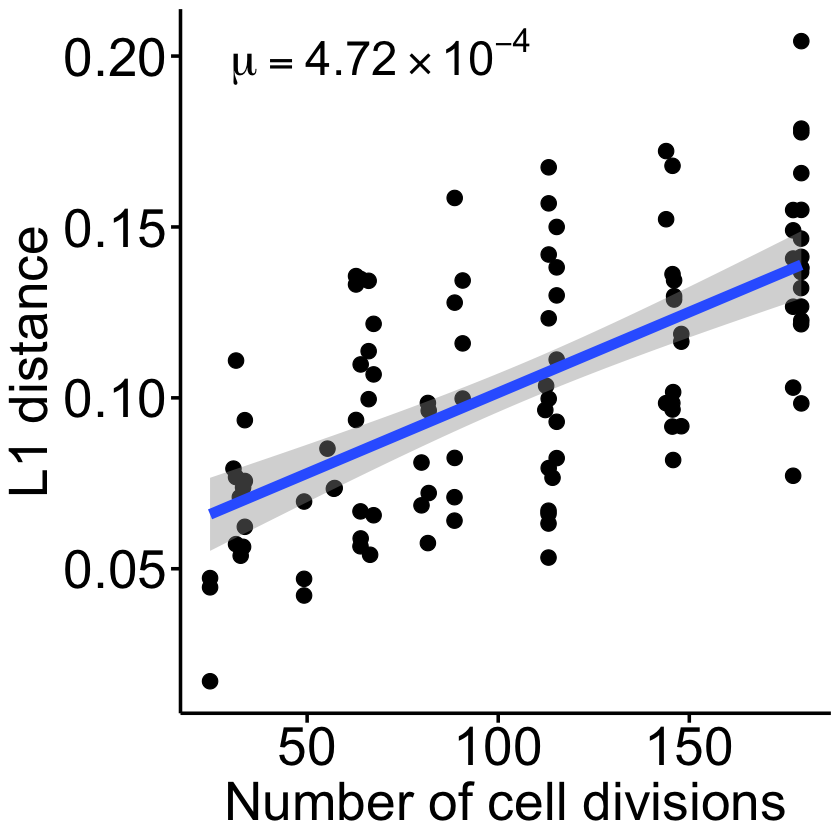

In [43]:
msi_generation_l1 <- msi_generations %>%
    ggplot(aes(generations, l1)) +
    geom_point(size = 4) +
    geom_smooth(method = "lm", size = 3) +
    annotate("text", 30, 0.2, label = mu_msi_annotation, size = 10, parse = TRUE, hjust = 0) +
    theme_martin() +
    labs(
        x = "Number of cell divisions",
        y = "L1 distance"
    )
msi_generation_l1

In [42]:
# calculating mutation rate based on slope
mu_mss <- coef((lm(mss_generations$l1 ~ mss_generations$generations)))[2]
mu_mss_form <- sub("e", " %*% 10^", format(mu_mss, digits=3, scientific = TRUE))
mu_mss_annotation <- paste0("mu == ", mu_mss_form)

`geom_smooth()` using formula = 'y ~ x'


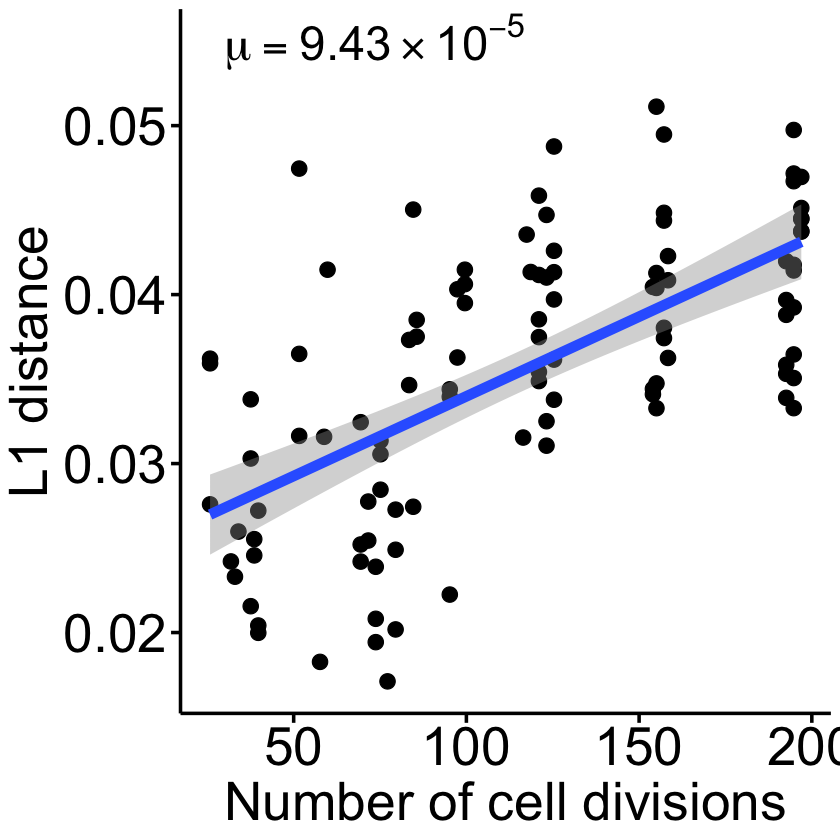

In [16]:
mss_generation_l1 <- mss_generations %>%
    ggplot(aes(generations, l1)) +
    geom_point(size = 4) +
    geom_smooth(method = "lm", size = 3) +
    annotate("text", 30, 0.055, label = mu_mss_annotation, size = 10, parse = TRUE, hjust = 0) +
    theme_martin() +
    labs(
        x = "Number of cell divisions",
        y = "L1 distance"
    )
mss_generation_l1


## Plotting trees based on experimental set-up

Creating neighbor joining trees in which the distance between samples is the number of generations that separates them. This will give the topology that was created during the in-vitro evolution experiment.

### MSI Tree

In [48]:
# changing the original names to make the sample relationship easier understandable in the figure
msi_renamed  <- msi_generations  %>% 
    mutate(a=case_when(A=="M2"~"MMRd-root",
                      str_detect(A, "A")&str_count(A)==2~"MMRd-A",
                      str_detect(A, "B")&str_count(A)==2~"MMRd-B",
                      str_detect(A, "C")&str_count(A)==2~"MMRd-C",
                      str_detect(A, "A")&str_count(A)==4~"MMRd-A1",
                      str_detect(A, "B")&str_count(A)==4~"MMRd-B1",
                      str_detect(A, "C")&str_count(A)==4~"MMRd-C1",
                      A=="A33311" ~ "MMRd-A1a",
                      A=="A33322" ~ "MMRd-A1b",
                      A=="A3333C" ~ "MMRd-A1c",
                      A=="B21418" ~ "MMRd-B1a",
                      A=="B21419" ~ "MMRd-B1b",
                      A=="B21435" ~ "MMRd-B1c",
                      A=="C93113" ~ "MMRd-C1a",
                      A=="C93133" ~ "MMRd-C1b"),
          b=case_when(B=="M2"~"MMRd-root",
                      str_detect(B, "A")&str_count(B)==2~"MMRd-A",
                      str_detect(B, "B")&str_count(B)==2~"MMRd-B",
                      str_detect(B, "C")&str_count(B)==2~"MMRd-C",
                      str_detect(B, "A")&str_count(B)==4~"MMRd-A1",
                      str_detect(B, "B")&str_count(B)==4~"MMRd-B1",
                      str_detect(B, "C")&str_count(B)==4~"MMRd-C1",
                      B=="A33311" ~ "MMRd-A1a",
                      B=="A33322" ~ "MMRd-A1b",
                      B=="A3333C" ~ "MMRd-A1c",
                      B=="B21418" ~ "MMRd-B1a",
                      B=="B21419" ~ "MMRd-B1b",
                      B=="B21435" ~ "MMRd-B1c",
                      B=="C93113" ~ "MMRd-C1a",
                      B=="C93133" ~ "MMRd-C1b"))

In [49]:
# setting up a distance matrix 
correct_samples_msi  <- msi_renamed  %>%  
    select(a,b,generations)

reversed_samples_msi  <- msi_renamed  %>% 
    rename(a=b, b=a)  %>% 
    select(a,b,generations)

combined_generations_msi  <- bind_rows(correct_samples_msi, reversed_samples_msi)  %>% 
     pivot_wider(names_from=b, values_from=generations)

In [50]:
# reordering the distance matrix
dist_mat_msi  <- combined_generations_msi[match(colnames(combined_generations_msi), combined_generations_msi$a) %>% na.omit, ] %>% 
  column_to_rownames("a")  %>% 
  as.dist()

# creating a neighbor joining tree
msi_tree  <- nj(dist_mat_msi)
rooted_msi_tree <- phytools::reroot(msi_tree, node.number = which(msi_tree$tip.label == "MMRd-root")) %>%
  ape::rotate(16, polytom = c(16, 29))

! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.



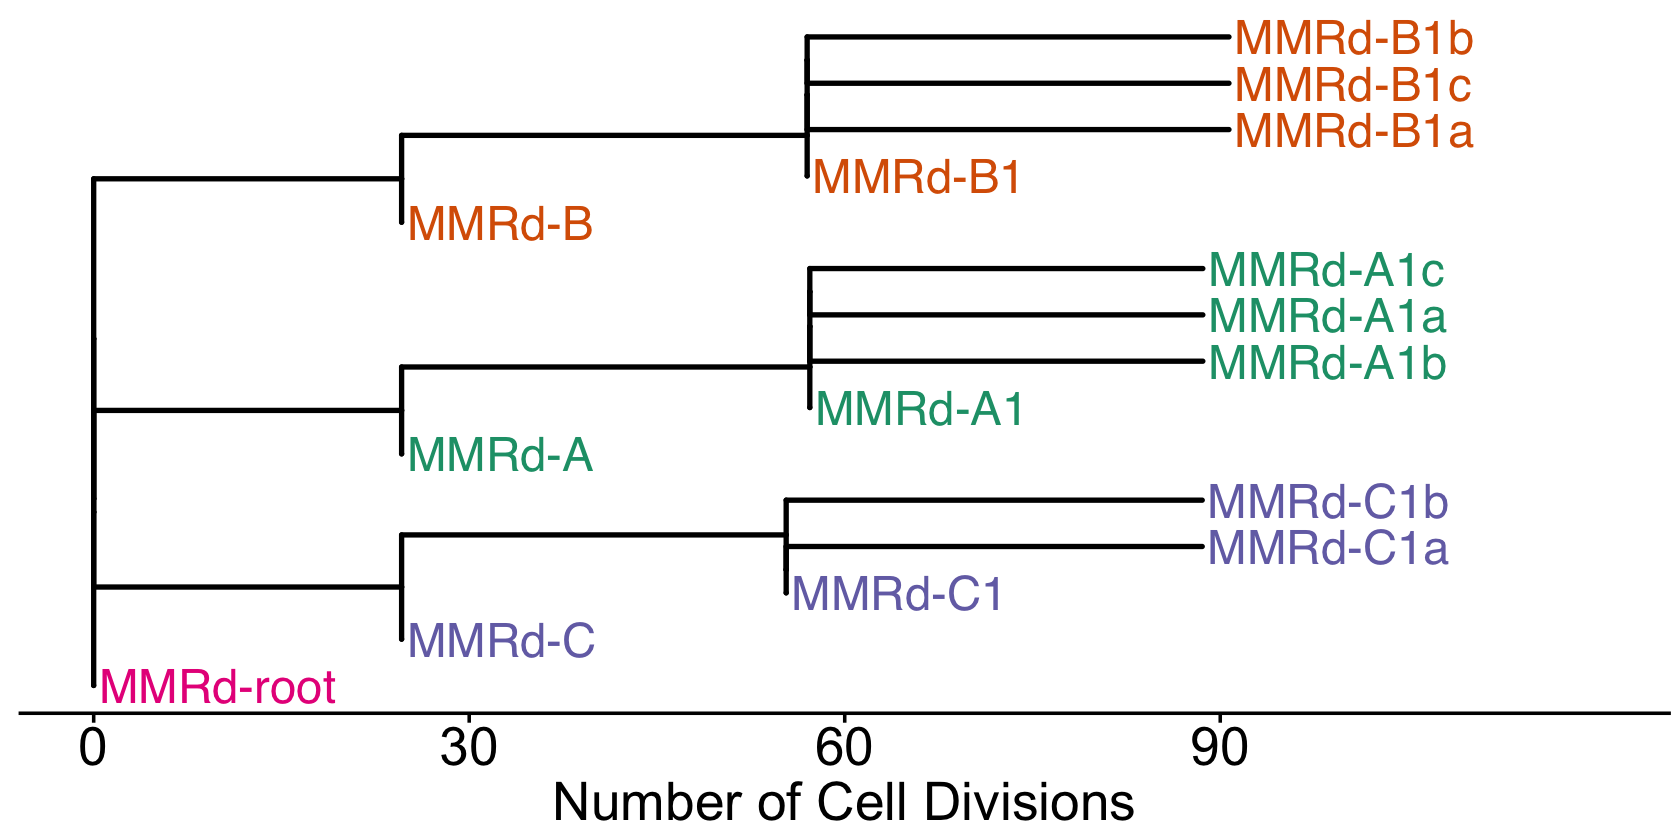

In [51]:
options(repr.plot.height=7, repr.plot.width=14)

gtree_msi  <- ggtree(rooted_msi_tree, size=1.5) 
gtree_msi$data  <- gtree_msi$data  %>% 
    mutate(clade=str_extract(label, "(?<=MMRd).{2}"))

msi_correct_tree  <- gtree_msi +
    geom_tiplab(aes(color=clade), size=10) +
    scale_color_brewer(palette = "Dark2", guide="none") +
    theme_tree2() +
    scale_x_continuous(name="Number of Cell Divisions",
                    breaks=c(0, 30, 60, 90)) +
    coord_cartesian(xlim = c(0, 120)) +
        theme_martin() +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.line.y = element_blank()) 
msi_correct_tree <- msi_correct_tree %>%
    flip(20, 21) %>%
    flip(28, 13)

msi_correct_tree   

### MSS

In [44]:
# changing the original names to make the sample relationship easier understandable in the figure
mss_renamed  <- mss_generations  %>% 
    mutate(a=case_when(A=="M3"~"MMRp-root",
                      str_detect(A, "E6")&str_count(A)==2~"MMRp-A",
                      str_detect(A, "G6")&str_count(A)==2~"MMRp-B",
                      str_detect(A, "E5")&str_count(A)==2~"MMRp-C",
                      str_detect(A, "E6")&str_count(A)==4~"MMRp-A1",
                      str_detect(A, "G6")&str_count(A)==4~"MMRp-B1",
                      str_detect(A, "E5")&str_count(A)==4~"MMRp-C1",
                      A=="E63313" ~ "MMRp-A1a",
                      A=="E6332A" ~ "MMRp-A1b",
                      A=="E63336" ~ "MMRp-A1c",
                      A=="G62332" ~ "MMRp-B1a",
                      A=="G62333" ~ "MMRp-B1b",
                      A=="G62335" ~ "MMRp-B1c",
                      A=="E53311" ~ "MMRp-C1a",
                      A=="E53315" ~ "MMRp-C1b"),
          b=case_when(B=="M3"~"MMRp-root",
                      str_detect(B, "E6")&str_count(B)==2~"MMRp-A",
                      str_detect(B, "G6")&str_count(B)==2~"MMRp-B",
                      str_detect(B, "E5")&str_count(B)==2~"MMRp-C",
                      str_detect(B, "E6")&str_count(B)==4~"MMRp-A1",
                      str_detect(B, "G6")&str_count(B)==4~"MMRp-B1",
                      str_detect(B, "E5")&str_count(B)==4~"MMRp-C1",
                      B=="E63313" ~ "MMRp-A1a",
                      B=="E6332A" ~ "MMRp-A1b",
                      B=="E63336" ~ "MMRp-A1c",
                      B=="G62332" ~ "MMRp-B1a",
                      B=="G62333" ~ "MMRp-B1b",
                      B=="G62335" ~ "MMRp-B1c",
                      B=="E53311" ~ "MMRp-C1a",
                      B=="E53315" ~ "MMRp-C1b"))

In [45]:
correct_samples  <- mss_renamed  %>% 
    select(a,b,generations)

reversed_samples  <- mss_renamed  %>% 
    select(a,b,generations)  %>% 
    rename(a=b, b=a)
combined_generations  <- bind_rows(correct_samples, reversed_samples)  %>% 
     pivot_wider(names_from=b, values_from=generations)

In [46]:
dist_mat  <- combined_generations[match(colnames(combined_generations), combined_generations$a) %>% na.omit, ] %>% 
  column_to_rownames("a")  %>% 
  as.dist()

mss_tree  <- nj(dist_mat)
rooted_mss_tree  <- phytools::reroot(mss_tree, node.number=which(mss_tree$tip.label=="MMRp-root"))

! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.



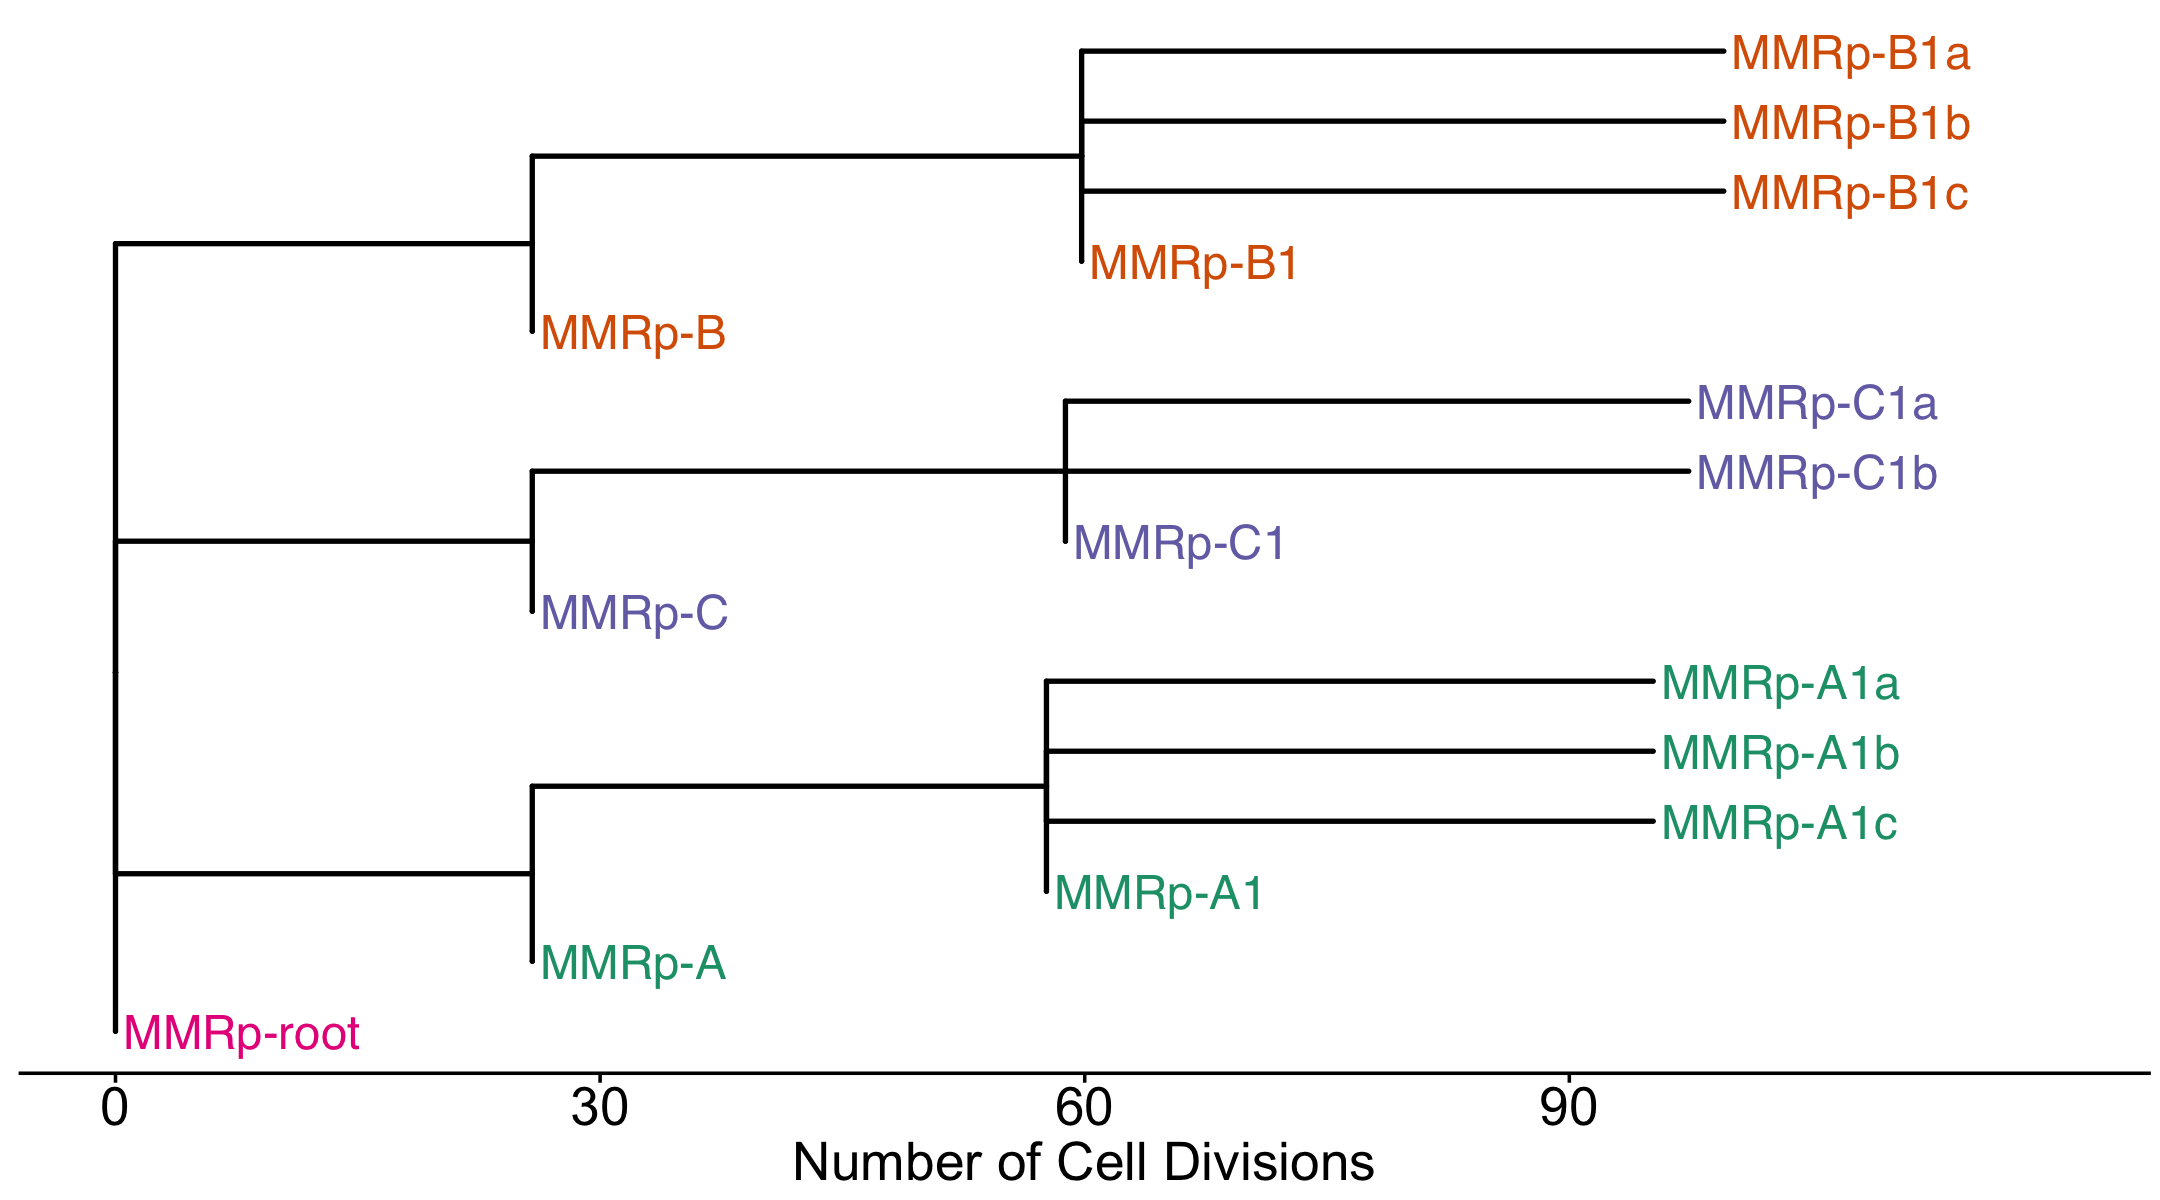

In [47]:
rooted_mss_tree <- di2multi(rooted_mss_tree) 
ggtree_mss  <- ggtree(rooted_mss_tree, size=1.5) 
ggtree_mss$data  <- ggtree_mss$data  %>% 
    mutate(clade=str_extract(label, "(?<=MMRp).{2}"))

mss_correct_tree <- ggtree_mss +
    geom_tiplab(aes(color = clade), size = 10) +
    scale_color_brewer(palette = "Dark2", guide = "none") +
    theme_tree2() +
    scale_x_continuous(
        name = "Number of Cell Divisions",
        breaks = c(0, 30, 60, 90)
    ) +
    coord_cartesian(xlim = c(0, 120)) +
        theme_martin() +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.line.y = element_blank()) 
mss_correct_tree <- mss_correct_tree %>%
    flip(18, 19) %>%
    flip(10, 11) %>%
    flip(5, 6) %>%
    flip(3, 2)%>% 
    flip(8, 7)

mss_correct_tree

## Plotting L1 Trees based on polyG data

In [24]:
# create distance matrix with all pairwise L1 distances
correct_samples_msi_l1  <- msi_renamed  %>% 
    select(a,b,l1)

reversed_samples_msi_l1  <- msi_renamed  %>% 
    select(a,b,l1)  %>% 
    rename(a=b, b=a)

combined_l1_msi  <- bind_rows(correct_samples_msi_l1, reversed_samples_msi_l1)  %>% 
     pivot_wider(names_from=b, values_from=l1)

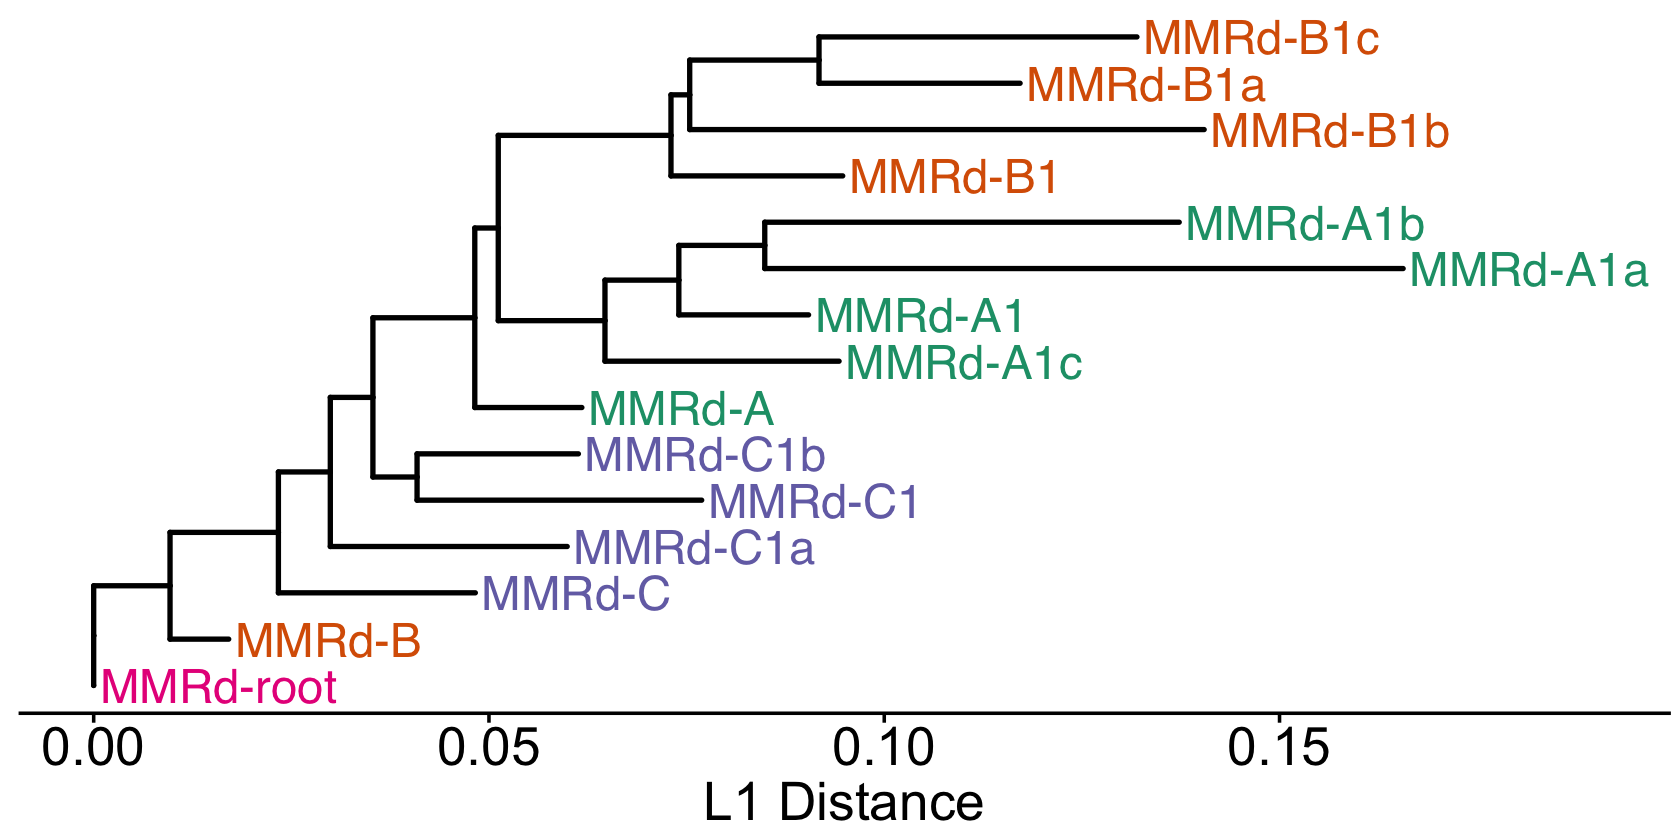

In [52]:
l1_dist_mat_msi  <- combined_l1_msi[match(colnames(combined_l1_msi), combined_l1_msi$a) %>% na.omit, ] %>% 
  column_to_rownames("a")  %>% 
  as.dist()

# create neighbor joining tree and root it 
l1_msi_tree  <- nj(l1_dist_mat_msi)
rooted_l1_msi_tree  <- phytools::reroot(l1_msi_tree, node.number=which(l1_msi_tree$tip.label=="MMRd-root"))

# plot tree and add clade names for coloring
l1_gtree_msi <- ggtree(rooted_l1_msi_tree, size = 1.5)
l1_gtree_msi$data  <- l1_gtree_msi$data  %>% 
    mutate(clade=str_extract(label, "(?<=MMRd).{2}"))

msi_measured_tree  <- l1_gtree_msi +
    geom_tiplab(aes(color=clade), size=10) +
    scale_color_brewer(palette = "Dark2", guide="none") +
    theme_tree2() +
    labs(x="L1 Distance") +
    coord_cartesian(xlim=c(0, 0.19)) +
    theme_martin()  +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.line.y = element_blank())
msi_measured_tree

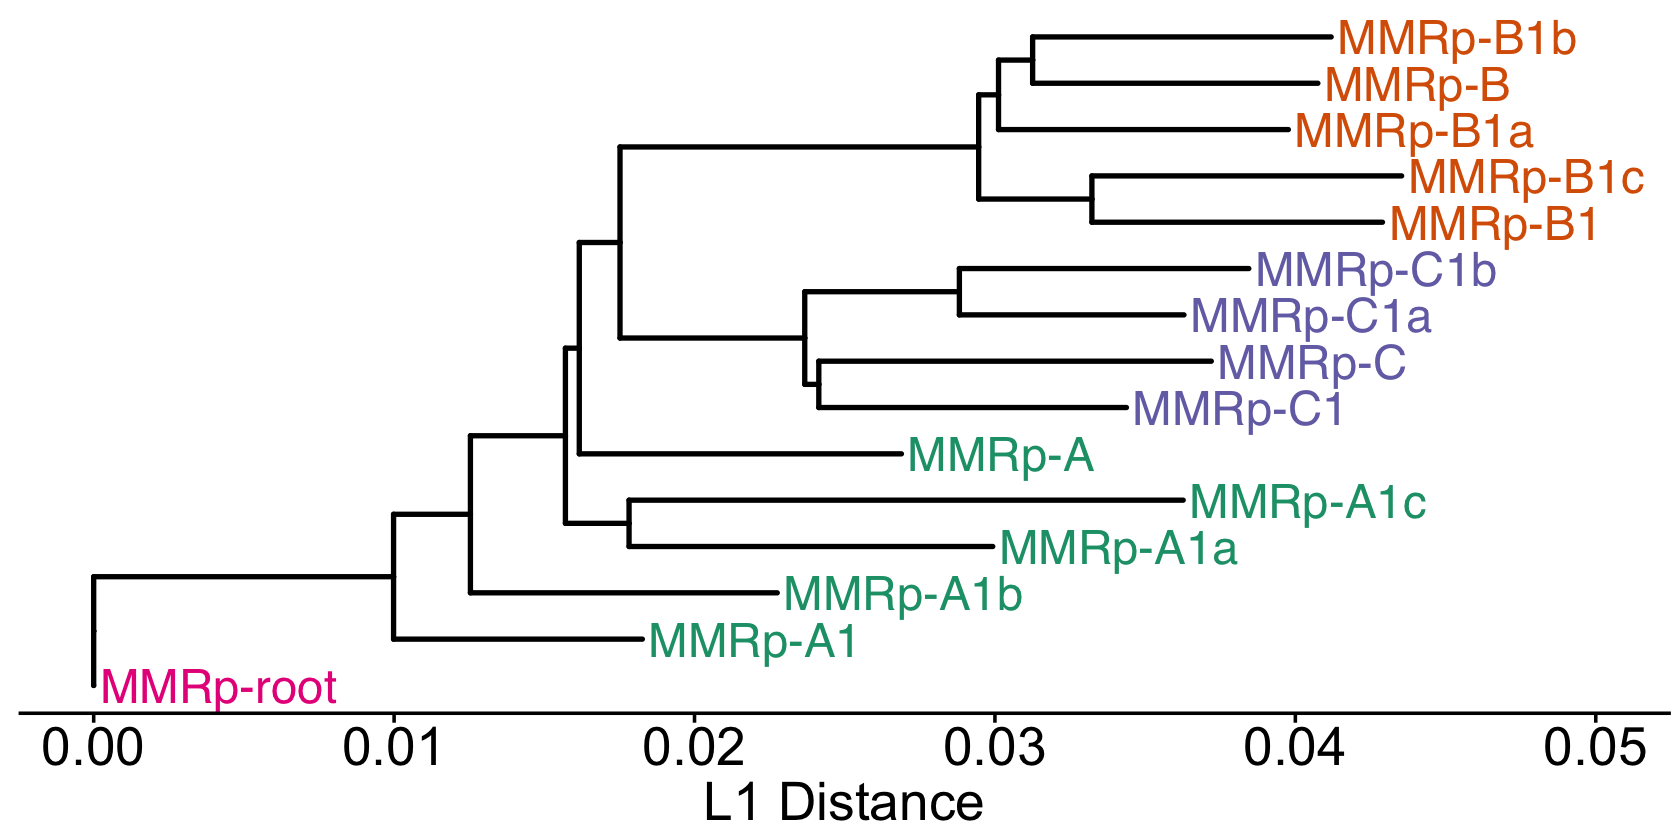

In [53]:
# create distance matrix with all pairwise L1 distances
correct_samples_MSS_l1  <- mss_renamed  %>% 
    select(a,b,l1)

reversed_samples_MSS_l1  <- mss_renamed  %>% 
    select(a,b,l1)  %>% 
    rename(a=b, b=a)

combined_l1_MSS  <- bind_rows(correct_samples_MSS_l1, reversed_samples_MSS_l1)  %>% 
     pivot_wider(names_from=b, values_from=l1)

l1_dist_mat_MSS  <- combined_l1_MSS[match(colnames(combined_l1_MSS), combined_l1_MSS$a) %>% na.omit, ] %>% 
  column_to_rownames("a")  %>% 
  as.dist()

# create neighbor joining tree and root it 
l1_MSS_tree  <- nj(l1_dist_mat_MSS)
rooted_l1_MSS_tree  <- phytools::reroot(l1_MSS_tree, node.number=which(l1_MSS_tree$tip.label=="MMRp-root"))

# plot tree and add clade names for coloring
l1_gtree_MSS <- ggtree(rooted_l1_MSS_tree, size = 1.5)
l1_gtree_MSS$data  <- l1_gtree_MSS$data  %>% 
    mutate(clade=str_extract(label, "(?<=MMRp).{2}"))

mss_measured_tree  <- l1_gtree_MSS +
    geom_tiplab(aes(color=clade), size=10) +
    scale_color_brewer(palette = "Dark2", guide="none") +
    theme_tree2() +
    labs(x="L1 Distance") +
    coord_cartesian(xlim=c(0, 0.05)) +
    theme_martin()  +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.line.y = element_blank())
mss_measured_tree

## Combing plots into single layout

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


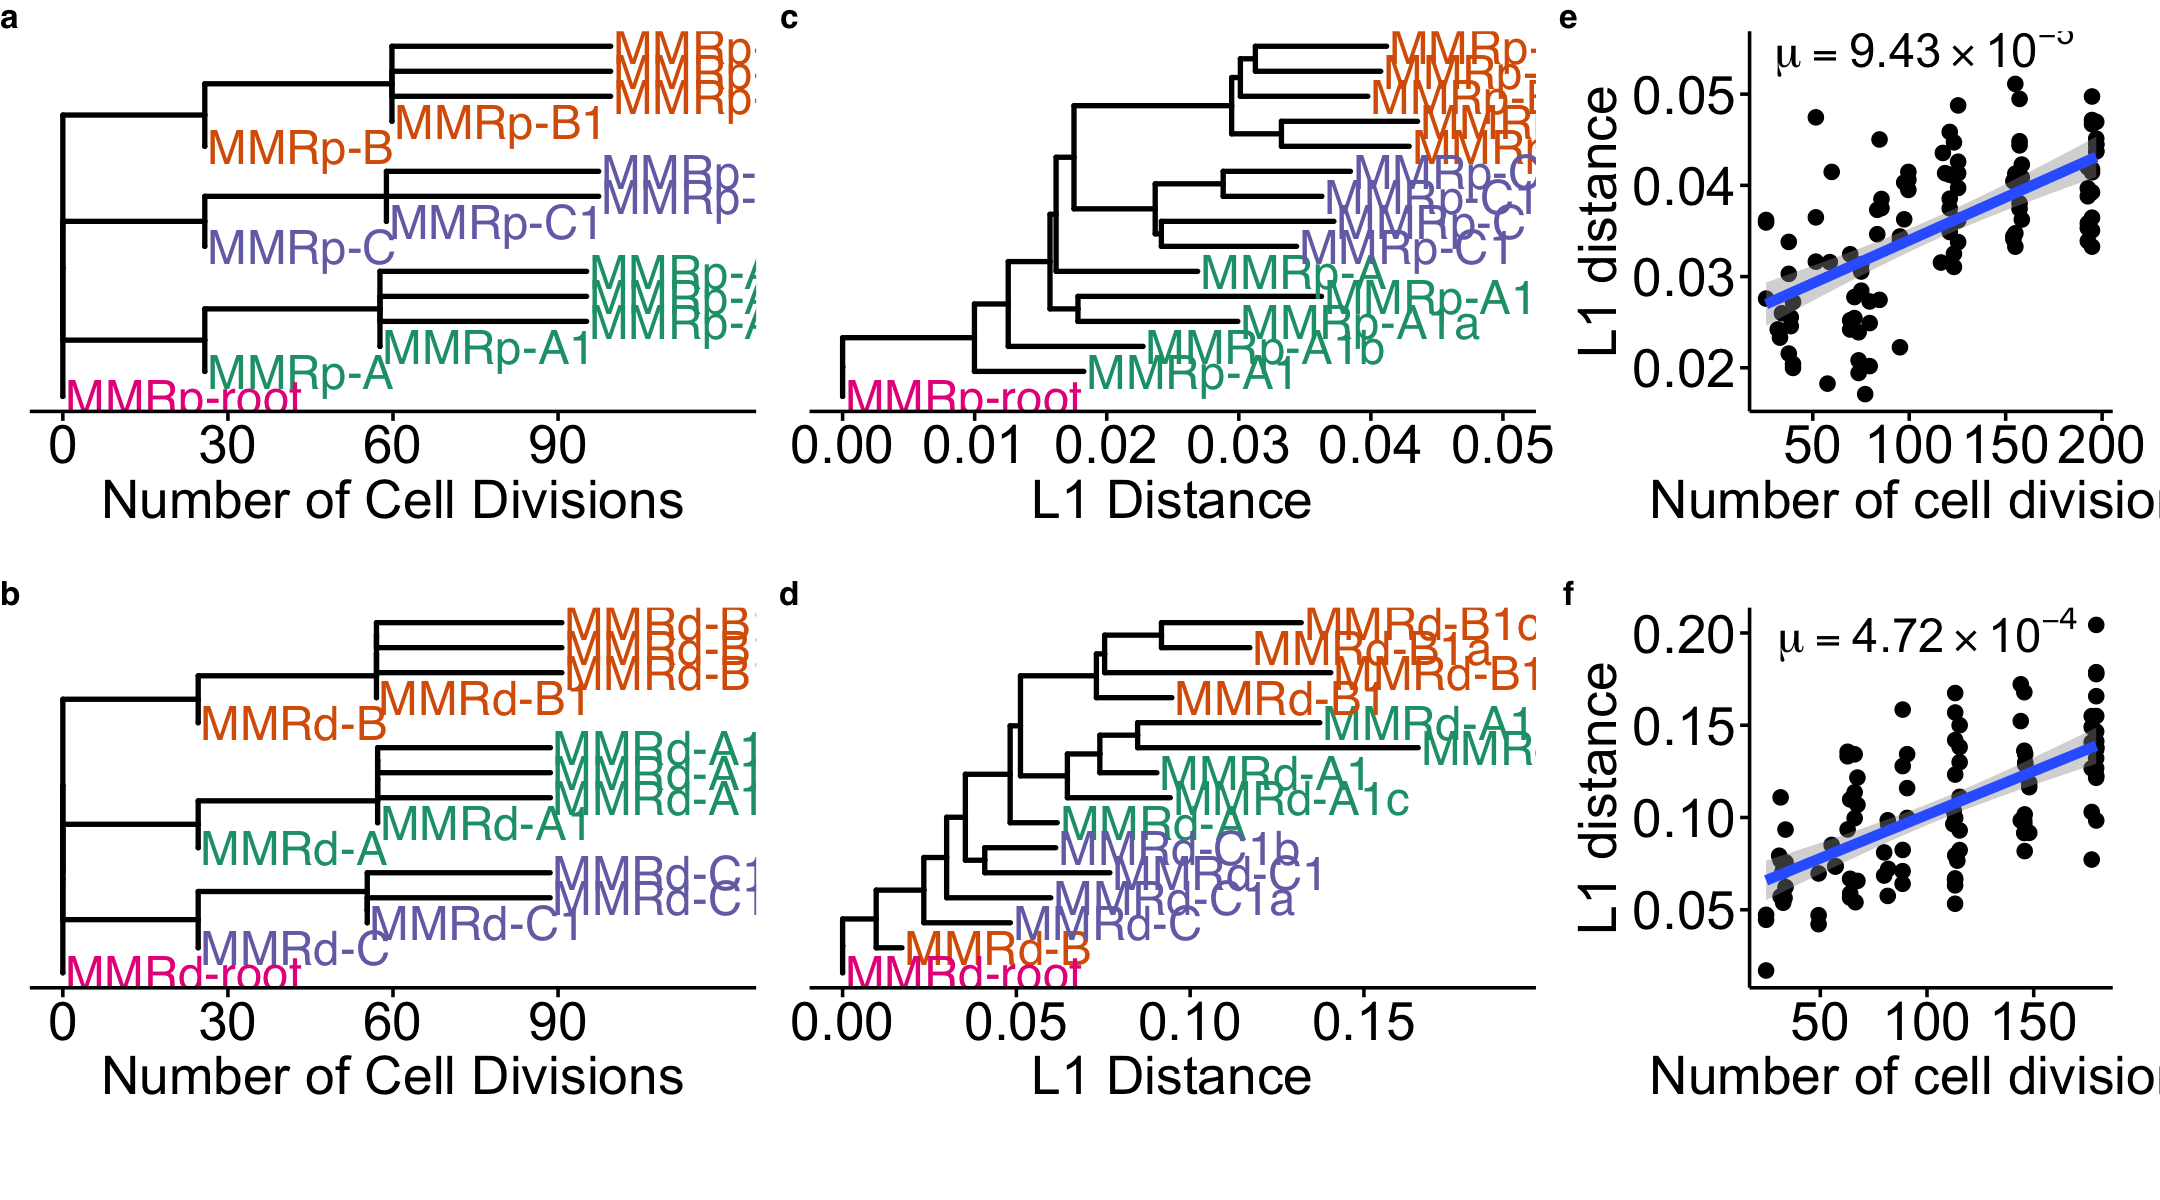

In [28]:
options(repr.plot.height=10, repr.plot.width=18)


Fig2  <- (mss_correct_tree +msi_correct_tree + mss_measured_tree + msi_measured_tree + mss_generation_l1 + msi_generation_l1) +
     plot_layout(ncol = 3, nrow=2, byrow = FALSE,
         widths = c(2, 2, 1)) +
    plot_annotation(tag_levels = 'a') &
    theme(plot.margin =    margin(0, 0.5, 1, 0, "cm"), plot.tag = element_text(face = "bold",
                                                                              family="Helvetica", 
                                                                               size=20)) 
Fig2
ggsave("../plots/Figure2/Fig2.pdf", Fig2, height=16, width=33)

## Numbers for the text

Cell division numbers

In [54]:
cell_divs_tbl

sample_name,divisions
<chr>,<dbl>
MSS_M3,25.80000
MSI_M2,24.60000
MSS_E6,31.83070
MSS_G6,34.00872
MSS_E5,33.00658
MSI_A3,32.61097
MSI_B2,32.39854
MSI_C9,30.72278
MSS_E6_32,38.44348


In [55]:
min(cell_divs_tbl$divisions)
max(cell_divs_tbl$divisions)

[1] 24.6

[1] 45.92557

Mutation rates

In [56]:
# MSS
format(coef(lm(mss_generations$l1 ~ mss_generations$generations))[2], scientific=T)

mss_generations$generations 
              "9.43139e-05"

In [57]:
# MSI
format(coef(lm(msi_generations$l1 ~ msi_generations$generations))[2], scientific=T)

msi_generations$generations 
              "4.71906e-04"

Intrasample heterogeneity (generated by genetic diversity and noise) is represented by the y intercept. It is converted into cell divisions.

In [58]:
coef(lm(msi_generations$l1 ~ msi_generations$generations))[1]/coef(lm(msi_generations$l1 ~ msi_generations$generations))[2]

(Intercept) 
   115.0791

In [59]:
coef(lm(mss_generations$l1 ~ mss_generations$generations))[1]/coef(lm(mss_generations$l1 ~ mss_generations$generations))[2]

(Intercept) 
   260.2802

Correlations of L1 and cell divisions.

In [34]:
# MSS
cor.test(mss_generations$l1, mss_generations$generations)


	Pearson's product-moment correlation

data:  mss_generations$l1 and mss_generations$generations
t = 8.2658, df = 103, p-value = 5.1e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5004088 0.7342938
sample estimates:
      cor 
0.6315057 


In [35]:
# MSI
cor.test(msi_generations$l1, msi_generations$generations)


	Pearson's product-moment correlation

data:  msi_generations$l1 and msi_generations$generations
t = 8.403, df = 103, p-value = 2.552e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5081982 0.7390707
sample estimates:
      cor 
0.6377446 


In [21]:
msi_generations %>%
    mutate(mu = (l1-0.0543064932213356) / generations) %>%
    summarise(mu = mean(mu)) %>%
    pull(mu) %>%
    format(scientific = T)

[1] "4.583912e-04"

In [22]:
msi_generations %>%
    mutate(mu = (l1) / generations) %>%
    summarise(mu = mean(mu)) %>%
    pull(mu) %>%
    format(scientific = T)

[1] "1.163548e-03"

In [18]:
mss_generations %>%
    mutate(mu = (l1-0.0245480445963985) / generations) %>%
    summarise(mu = mean(mu)) %>%
    pull(mu) %>%
    format(scientific = T)

[1] "9.439488e-05"

In [23]:
mss_generations %>%
    mutate(mu = (l1) / generations) %>%
    summarise(mu = mean(mu)) %>%
    pull(mu) %>%
    format(scientific = T)

[1] "3.855011e-04"

In [20]:
coef(lm(msi_generations$l1 ~ msi_generations$generations))

(Intercept) msi_generations$generations 
                0.054306493                 0.000471906

In [16]:
coef(lm(mss_generations$l1 ~ mss_generations$generations))

(Intercept) mss_generations$generations 
               0.0245480446                0.0000943139

Expected mutations between two lineages

In [24]:
mss_renamed %>%
    mutate(exp_mut=9.43139014888478e-05*marker*generations) %>% 
    filter((a == "MMRp-A" & b == "MMRp-A1")|(a == "MMRp-B" & b == "MMRp-B1")) 

a,b,l1,r,marker,A,B,generations,exp_mut
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>
MMRp-A,MMRp-A1,0.02420799,0.3913285,58,E6,E633,31.83070,0.1741205
MMRp-B,MMRp-B1,0.02597599,0.9097804,58,G6,G623,34.00872,0.1860347


In [28]:
mss_renamed %>%
    mutate(exp_mut=9.43139014888478e-05*marker*generations)  %>% 
    filter(b == "MMRp-root")

a,b,l1,r,marker,A,B,generations,exp_mut
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>
MMRp-C,MMRp-root,0.03620848,NA,58,E5,M3,25.80000,0.1411313
MMRp-C1,MMRp-root,0.03158384,NA,58,E533,M3,58.80658,0.3216841
MMRp-C1a,MMRp-root,0.03627698,NA,58,E53311,M3,97.39156,0.5327519
MMRp-C1b,MMRp-root,0.04031410,NA,58,E53315,M3,97.39156,0.5327519
MMRp-A,MMRp-root,0.02758613,NA,58,E6,M3,25.80000,0.1411313
MMRp-A1,MMRp-root,0.01826399,NA,58,E633,M3,57.63070,0.3152518
MMRp-A1a,MMRp-root,0.03439764,NA,58,E63313,M3,95.19484,0.5207354
MMRp-A1b,MMRp-root,0.02224733,NA,58,E6332A,M3,95.19484,0.5207354
MMRp-A1c,MMRp-root,0.03395320,NA,58,E63336,M3,95.19484,0.5207354


Number of sample comparisons

In [16]:
msi_generations %>%
    nrow()
mss_generations %>%
    nrow()

[1] 105

[1] 105

## Bootstrapping mutation rate estimates

In [25]:
# finding combination of samples to bootstrap

get_boot_combos <- function(markerlengths, subject_i) {
      
      # find samples
      samples <- markerlengths %>% 
            filter(subject==subject_i) %>% 
            pull(sample) %>%
            unique()

      combos_wide <- combn(samples, m = 2) %>% as.data.frame()

      ## make combo table longer
      combos_long <- data.frame(a = as.character(combos_wide[1, ]), b = as.character(combos_wide[2, ]))
}


In [26]:
# function to the find the MRCA of a specific marker combination

boot_mu <- function(i, subject_i, subject_markers, n_markers, boot_combos, generations_tbl) {
        
        marker_table <- subject_markers %>%
            slice_sample(n = n_markers, replace = TRUE) %>%
            unnest(data) %>%
            select(subject, sample, marker, length) %>%
            ungroup()

        l1_comb_boot <- lapply(1:nrow(boot_combos), get_l1_r_for_combination, boot_combos, marker_table) %>%
            bind_rows()

        l1_gen_tbl <- l1_comb_boot %>%
            left_join(generations_tbl)
            
        coef((lm(l1_gen_tbl$l1 ~ l1_gen_tbl$generations)))[[2]]
        
    }

In [27]:
bootstrap_mu <- function(subject_i, markerlengths, generations_tbl) {
    
    # nesting markers
    subject_markers <- markerlengths %>%
        filter(subject == subject_i) %>% 
        group_by(subject, marker) %>% 
        nest %>% 
        ungroup 

    # getting combos to bootstrap through
    boot_combos <- get_boot_combos(markerlengths, subject_i)

    n_markers <- length(unique(subject_markers$marker))

    # number of bootstrap reps
    reps <- 1000
    mrca_boot <- parallel::mclapply(1:reps, boot_mu, subject_i, subject_markers, n_markers, boot_combos, generations_tbl)

    return(mrca_boot)
}

In [39]:
# setting up sample table with number of cell divisions between samples
msi_just_generations <- msi_generations %>%
    select(a, b, generations)

mss_just_generations <- mss_generations %>%
    select(a,b,generations)

In [42]:
msi_just_generations %>%
    write_tsv("../results/mmrd_divisions.tsv")

mss_just_generations %>%
    write_tsv("../results/mmrp_divisions.tsv")
markerlengths %>%
    write_tsv("../results/invitro_meanlengths.tsv")

In [33]:
msi_mu_l <- bootstrap_mu("MSI1", markerlengths, msi_just_generations)

In [ ]:
mss_mu_l <- bootstrap_mu("MSS1", markerlengths, mss_just_generations)

In [117]:
quantile(unlist(msi_mu_l), 0.025) %>% 
    format(scientific = TRUE)
quantile(unlist(msi_mu_l), 0.975) %>% 
    format(scientific = TRUE)

2.5% 
"2.924559e-04"

97.5% 
"6.858374e-04"

In [118]:
quantile(unlist(mss_mu_l), 0.025) %>% 
    format(scientific = TRUE)
quantile(unlist(mss_mu_l), 0.975) %>% 
    format(scientific = TRUE)

2.5% 
"1.19644e-05"

97.5% 
"2.226362e-04"

## Tree similarity 
Analyzing how similar real trees and inferred trees are

In [28]:
# function to scramble the tree labels for a permutation test
permute_quartet <- function(test_tree, constant_tree) {
    test_tree$tip.label <- sample(test_tree$tip.label[1:length(test_tree$tip.label)])
    status <- QuartetStatus(test_tree, cf = constant_tree)
    QuartetDivergence(status)
}

MSS

In [79]:
# calculating quartet divergence from real and inferred tree
status <- QuartetStatus(rooted_l1_MSS_tree, cf = rooted_mss_tree)
real_dist <- QuartetDivergence(status)
real_dist
# permuting 10,000 times
permuted_qs <- replicate(10000, permute_quartet(rooted_l1_MSS_tree, rooted_mss_tree))

[1] 0.8102564

In [80]:
quartet_mss_fig <- tibble(r_qs = permuted_qs) %>%
    ggplot(aes(r_qs)) +
    geom_histogram(color = "white", alpha = 0.8, linewidth = 0.5, binwidth = 0.02) +
    geom_vline(xintercept = real_dist, color = "red", size = 2, linetype = 2) +
    coord_cartesian(xlim = c(0, 1)) +
    labs(x = "Tree similarity", y = "N permutations") +
    theme_martin()

P value:

In [81]:
distribution <- ecdf(permuted_qs)
1-distribution(real_dist)

[1] 0

MSI

In [86]:
# calculating quartet divergence from real and inferred tree
status <- QuartetStatus(rooted_l1_msi_tree, cf = rooted_msi_tree)
real_dist <- QuartetDivergence(status)

# permuting 10,000 times
permuted_qs <- replicate(10000, permute_quartet(rooted_l1_msi_tree, rooted_msi_tree))

[1] 0.6644689

In [83]:
quartet_msi_fig <- tibble(r_qs = permuted_qs) %>%
    ggplot(aes(r_qs)) +
    geom_histogram(color = "white", alpha = 0.8, linewidth=0.5, binwidth = 0.02) +
    geom_vline(xintercept = real_dist, color = "red", size = 2, linetype = 2) +
    coord_cartesian(xlim = c(0, 1)) +
    labs(x = "Tree similarity", y = "N permutations") +
    theme_martin()

P value:

In [84]:
distribution <- ecdf(permuted_qs)
1-distribution(real_dist)

[1] 0

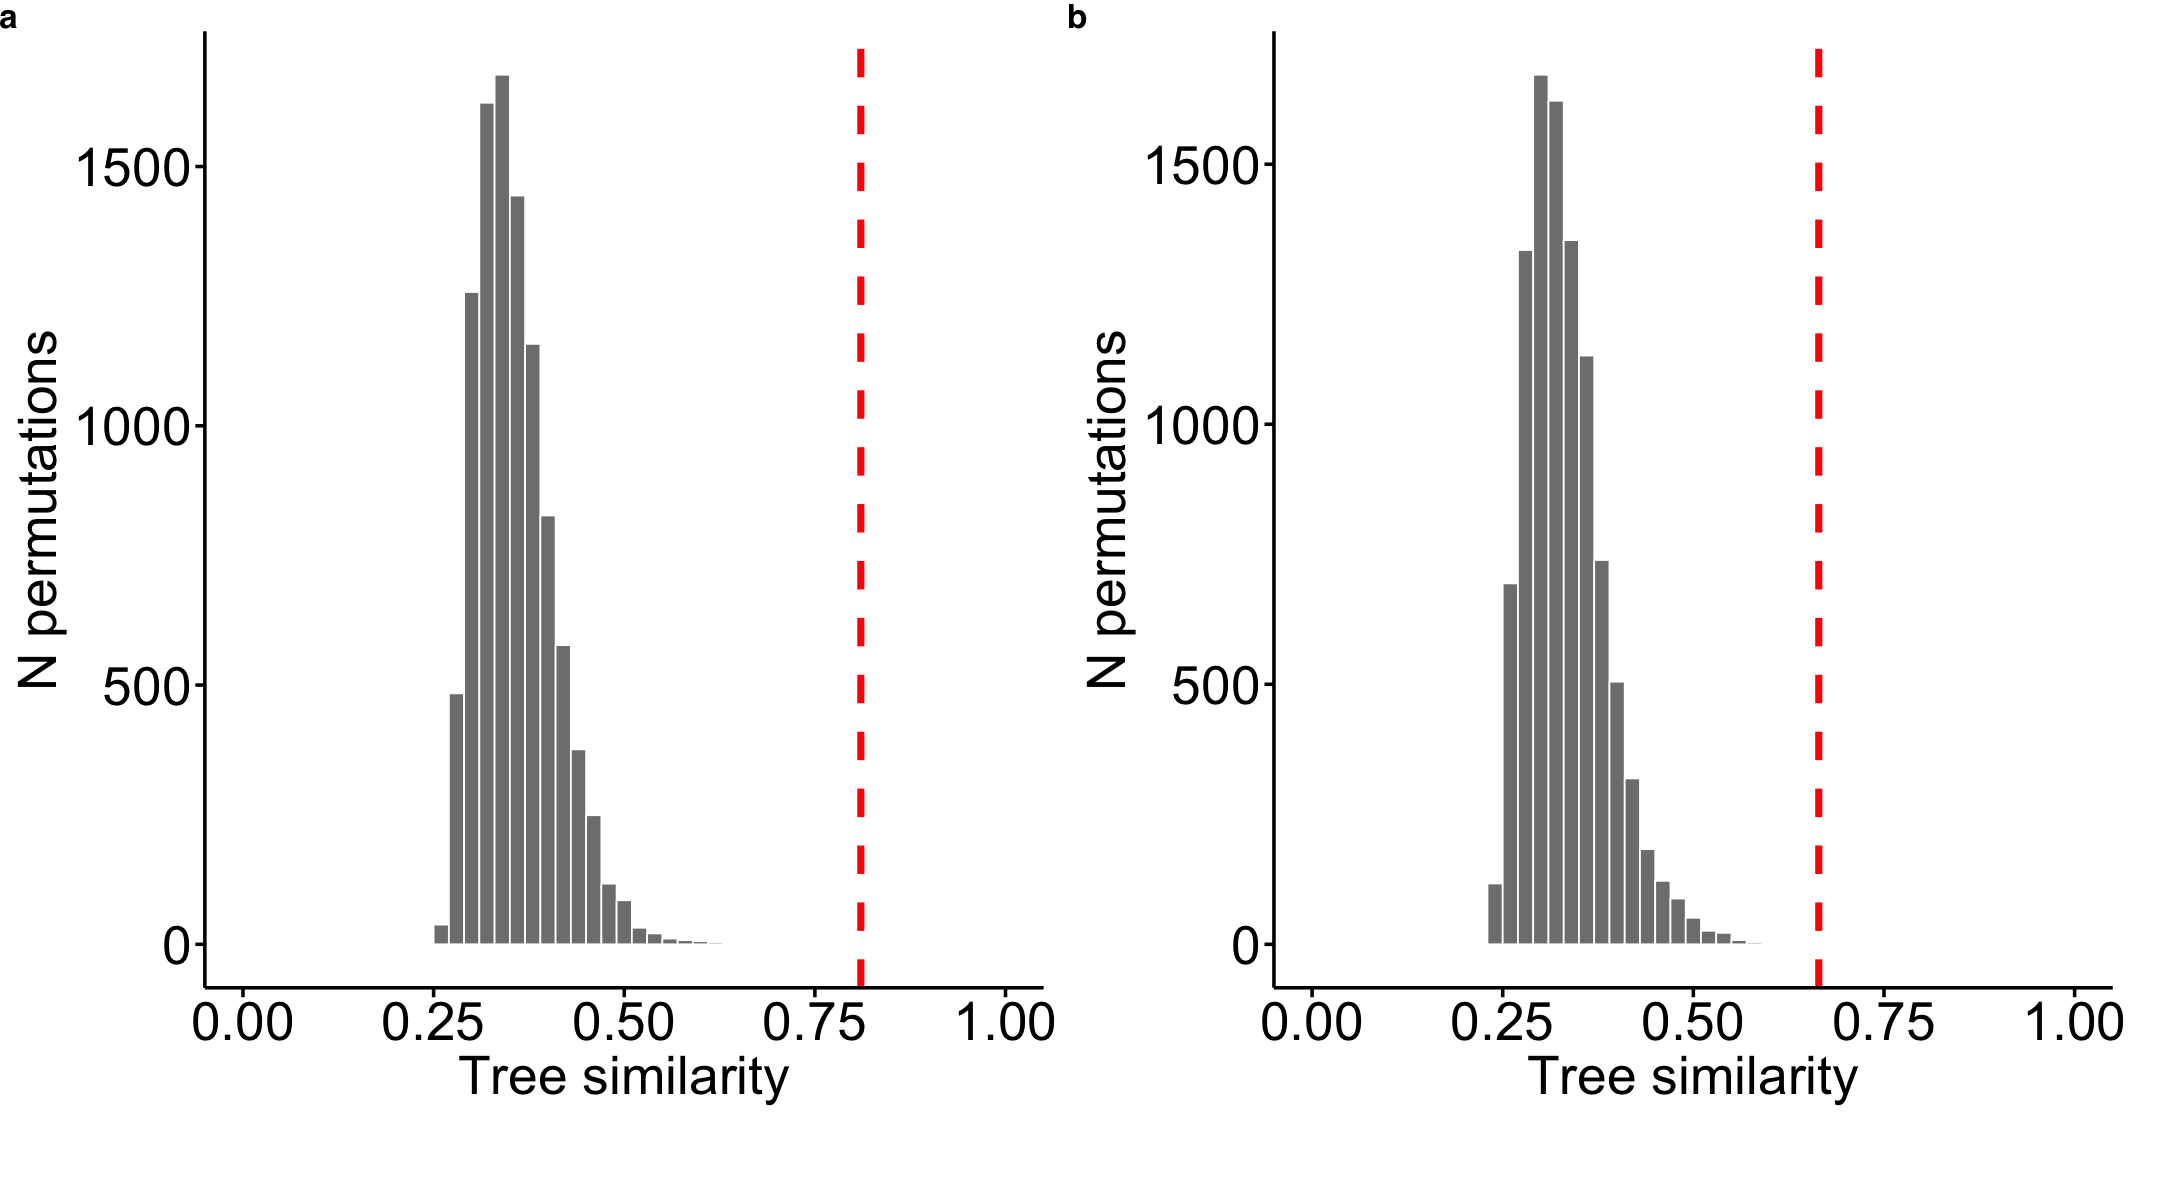

In [85]:
options(repr.plot.height=10, repr.plot.width=18)


(quartet_mss_fig +quartet_msi_fig) +
     plot_layout(ncol = 2, nrow=1, byrow = FALSE,
         widths = c(1, 1)) +
    plot_annotation(tag_levels = 'a') &
    theme(plot.margin =    margin(0, 0.5, 1, 0, "cm"), plot.tag = element_text(face = "bold",
                                                                              family="Helvetica", 
                                                                               size=20)) 

ggsave("../plots/Figure2/Extended_Data_Fig2.pdf", height=12, width=33)